In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter

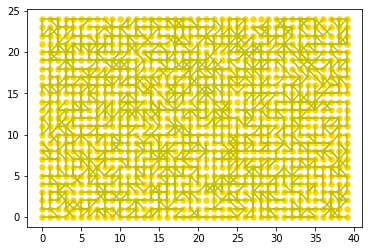

In [17]:
class Settings:
    def __init__(self, n_contacts = 4, radius = 2, duration = 200, k = 4, locations = [], m=40, n=25, gamma = 0.1, phi = 0.1):
        self.n_contacts = n_contacts
        self.radius = radius
        self.duration = duration
        self.k = k
        self.m = m
        self.n = n
        self.alpha_infected = 0.01
        self.alpha_exposed = 0.01
        self.alpha_recovered = 0
        self.susceptible = 0.98
        self.locations = locations
        self.gamma = gamma
        self.phi = phi
        self.beta_recover = 0.025
        self.beta_death = 0.0025
        
        
    def calc_position(self):
        return np.random.choice(["I","E","R","S"], 1, True, [self.alpha_infected,self.alpha_exposed,self.alpha_recovered,self.susceptible])[0]

       
class Simulation:
    def __init__(self, settings = Settings()):
        self.settings = settings
        self.population = []
        self.stage = []
        self.count = 0
        self.connections = []
        self.coords = []
        self.x = []  
        self.y = []
        self.status = []
        self.all_data = []
        self.individuals = []
        self.start_end = []
        if len(self.settings.locations) == 0:
            for i in range(self.settings.n):
                self.population.append([])
                for j in range(self.settings.m):
                    self.population[i].append(self.settings.calc_position())
                    if self.population[i][j] == 'I':
                        self.settings.locations.append((i, j))
        else:
            for i in range(self.settings.n):
                self.population.append([])
                for j in range(self.settings.m):
                    if (i, j) in self.settings.locations:
                        self.population[i].append('I')
                    else:
                        self.population[i].append('S')
        self.population = np.array(self.population)
                        

        for i in range(self.settings.n):
            self.coords.append([])
            for j in range(self.settings.m):
                self.coords[i].append((i,j))


        for i in range(self.settings.n):
            for j in range(self.settings.m):
                self.x.append(self.coords[i][j][1])
                self.y.append(self.coords[i][j][0])
                self.status.append(self.population[i,j])

        self.data_long = pd.DataFrame(list(zip(self.x, self.y,self.status)),
                       columns =['x', 'y', "status"])
        
        while self.count < (self.settings.m*self.settings.n*self.settings.k)/2:
            x1 = np.random.randint(0, self.population.shape[0])
            x2 = np.random.randint(0, self.population.shape[0])
            y1 = np.random.randint(0, self.population.shape[1])
            y2 = np.random.randint(0, self.population.shape[1])
            dist = abs(x1 - x2) + abs(y1 - y2)
            if dist <= settings.radius: 
                self.count += 1
                self.connections.append([(x1,y1), (x2,y2)]) 
                
        plt.scatter(self.data_long["x"], self.data_long["y"], marker='o', s=30, c="gold")
        for item in self.connections:
            x_values= [item[0][1], item[1][1]]
            y_values = [item[0][0], item[1][0]]
            plt.plot(x_values, y_values, "y")        
                
                
    
    def run(self):
        for i in range(self.settings.duration):
            self.stage.append(self.population.copy())
            
            for i in range(self.settings.n):
                for j in range(self.settings.m):
                    if self.population[i,j] == "E":
                        self.population[i,j] =  np.random.choice(["I","E"], 1, True, [self.settings.phi, 1-self.settings.phi])[0]

            for item in self.connections:
                if self.population[item[0][0],item[0][1]] == "S" and self.population[item[1][0], item[1][1]] == "I":
                    self.population[item[0][0],item[0][1]] = np.random.choice(["E","S"], 1, True, [self.settings.gamma, 1-self.settings.gamma])[0]
                elif self.population[item[0][0],item[0][1]] == "I" and self.population[item[1][0], item[1][1]] == "S": 
                    self.population[item[1][0], item[1][1]] = np.random.choice(["E","S"], 1, True, [self.settings.gamma, 1-self.settings.gamma])[0]

            for i in range(self.settings.n):
                for j in range(self.settings.m):
                    if self.population[i,j] == "I":
                        self.population[i,j] =  np.random.choice(["R","D","I"], 1, True, [self.settings.beta_recover, self.settings.beta_death, 1-self.settings.beta_recover-self.settings.beta_death])[0]
                        
        day = []
        for item in self.stage:
            for i in range(self.settings.n):
                for j in range(self.settings.m):
                    day.append(item[i,j]) 
        days = np.array(day)
        days = days.reshape(self.settings.duration, 1000)
        days = pd.DataFrame(days)
        days = days.T
        j = pd.DataFrame(list(zip(self.x, self.y)),
                       columns =['x', 'y']) 
        self.individuals = pd.concat([j, days], axis=1, join="inner")
        
        days = np.linspace(1,self.settings.duration,self.settings.duration)
        for s in self.stage:
            unique, counts = np.unique(s, return_counts = True)
            vals = dict(zip(unique, counts))
            data = pd.DataFrame(pd.Series(vals))
            data = data.T
            self.all_data.append(data)
        self.all_data = pd.concat(self.all_data)   
        self.all_data = self.all_data.set_index(days)
        self.all_data = self.all_data.fillna(0)
        self.all_data = self.all_data.eval("Day=index")

    def plot_state(self, time):
        status_by_stage = []
        for i in range(self.settings.n):
            for j in range(self.settings.m):
                status_by_stage.append(self.stage[time][i][j])
        self.data_long["status_by_stage"] = status_by_stage 
        colours = {"S":"gold", "I": "red", "R":"green", "E": "blue", "D": "black"} 
        plt.scatter(self.data_long["x"], self.data_long["y"], marker='o', s=30, c=self.data_long["status_by_stage"].map(colours) )
        for item in self.connections:
            x_values= [item[0][1], item[1][1]]
            y_values = [item[0][0], item[1][0]]
            plt.plot(x_values, y_values, "y")
                 
    def chart(self):
        plt.plot("Day", "E", data=self.all_data)
        plt.plot("Day", "I", data=self.all_data)
        plt.plot("Day", "D", data=self.all_data)
        plt.plot("Day", "R", data=self.all_data)
        plt.plot("Day", "S", data=self.all_data)
        plt.legend(labels = ["Exposed", "Infected", "Dead", "Recovered", "Susceptible"])
        
                
    def max_infected(self):
        return self.all_data.I.max()
    
    def peak_infected(self):
        return self.all_data.I.idxmax()
    
    
    
s = Simulation()
s.run()


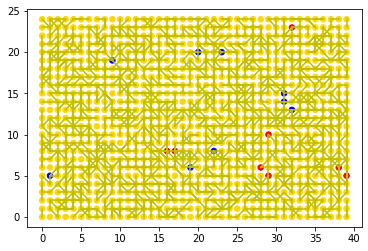

In [53]:
s.plot_state(0)

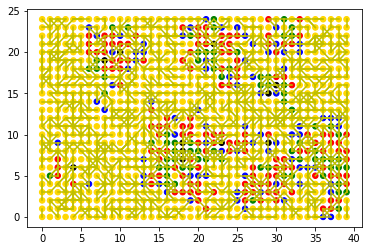

In [54]:
s.plot_state(50)

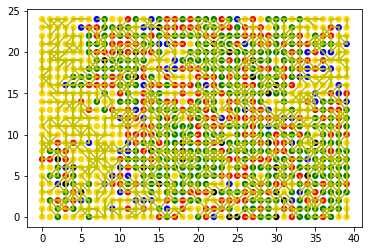

In [55]:
s.plot_state(100)

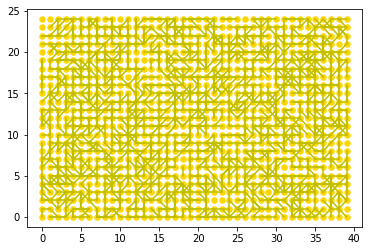

In [71]:
settings = Settings(locations = [(0,0),(1,0),(0,1),(1,1)], gamma=1.0, phi=1.0)
sim = Simulation(settings = settings )
sim.run()

<ipython-input-70-fbc8783170a6>:150: RuntimeWarning: Second argument 'D' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("Day", "D", data=self.all_data)
<ipython-input-70-fbc8783170a6>:151: RuntimeWarning: Second argument 'R' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("Day", "R", data=self.all_data)


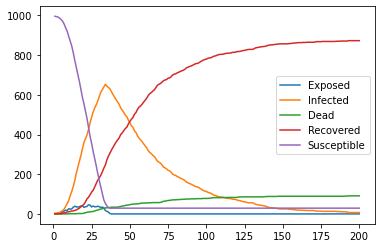

In [72]:
sim.chart()

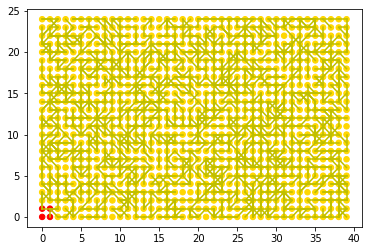

In [56]:
sim.plot_state(0)

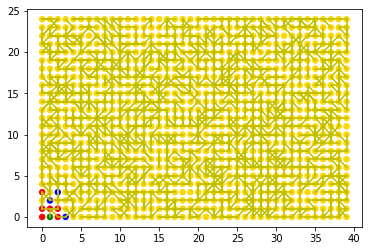

In [57]:
sim.plot_state(2)

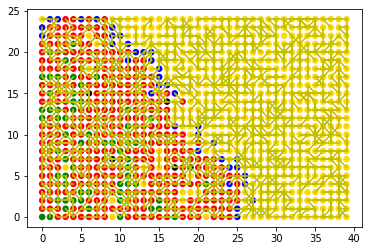

In [58]:
sim.plot_state(20)

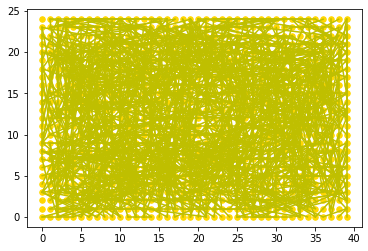

In [59]:
settings2 = Settings(radius = 10, locations = [(0,0),(1,0),(0,1),(1,1)], gamma=1.0, phi=1.0)
sim2 = Simulation(settings = settings2 )
sim2.run()

<ipython-input-50-3a367d4750cb>:149: RuntimeWarning: Second argument 'D' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("Day", "D", data=self.all_data)
<ipython-input-50-3a367d4750cb>:150: RuntimeWarning: Second argument 'R' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("Day", "R", data=self.all_data)


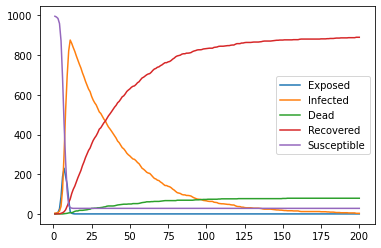

In [66]:
sim2.chart()

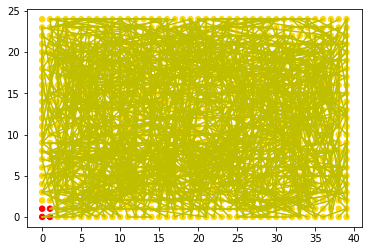

In [67]:
sim2.plot_state(0)

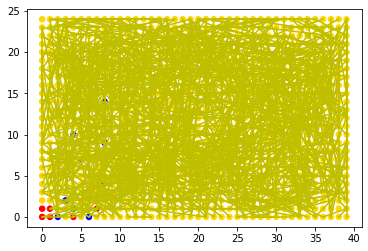

In [68]:
sim2.plot_state(2)

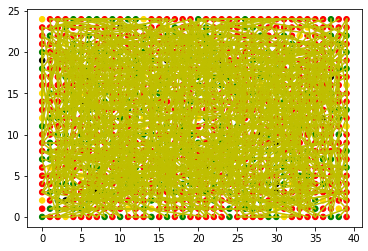

In [69]:
sim2.plot_state(20)

/Users/biancaoprisa/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/biancaoprisa/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 51., 122., 154., 167., 148.,  98.,  50.,  32.,  17.,   5.]),
 array([  1. ,  20.7,  40.4,  60.1,  79.8,  99.5, 119.2, 138.9, 158.6,
        178.3, 198. ]),
 <a list of 10 Patch objects>)

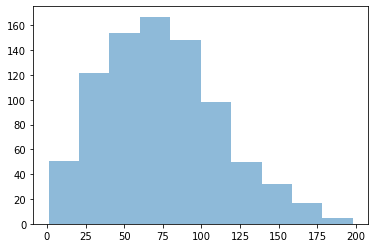

In [19]:
plt.hist(df["First Exposed"], alpha = 0.5)

We can see from the histogram that the highest values for the first exposed time is around day 75.

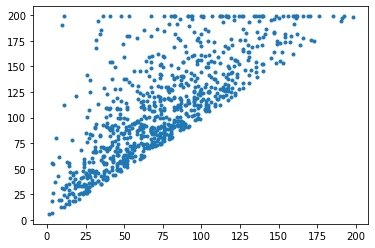

In [20]:
plt.plot(df["First Exposed"], df["Last Infection Time"], marker=".", linestyle="")

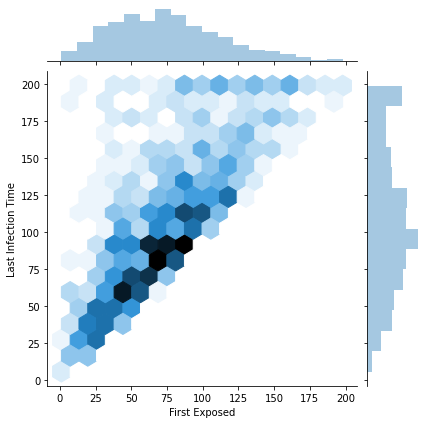

In [21]:
import seaborn as sns
sns.jointplot("First Exposed", "Last Infection Time", data=df, kind="hex")

The jointplot above depicts the joint distribution of the two variables First Exposed and Last Infection Time. We can see that the majority of the values lie between day 50 and day 125.